In [84]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import Imputer, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

import logging

details = pd.read_csv("player_details.csv", index_col=0, nrows=650)

test_week = 35
panel = pd.read_pickle("data.pkl").swapaxes(0,2)
# pick a week to test on:                                                                                                                                       
test = panel.loc[:, test_week, :]
ytest = test["target"]
logging.info("\n{}".format(test.head()))

train = panel.loc[:, 10:test_week, :].to_frame()  # flatten
train = train[train["target_minutes"]>120]
ytrain = train["target"]



In [92]:
m = panel.to_frame().index

In [95]:
m.levels[1]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            640, 641, 642, 643, 644, 645, 646, 647, 648, 649],
           dtype='int64', name='minor', length=650)

(array([  1.00000000e+00,   9.00000000e+00,   4.10000000e+01,
          1.25000000e+02,   8.85000000e+02,   1.40000000e+03,
          1.13100000e+03,   7.46000000e+02,   1.89000000e+02,
          1.70000000e+01]),
 array([ 0.        ,  0.36888795,  0.73777589,  1.10666384,  1.47555178,
         1.84443973,  2.21332767,  2.58221562,  2.95110356,  3.31999151,
         3.68887945]),
 <a list of 10 Patch objects>)

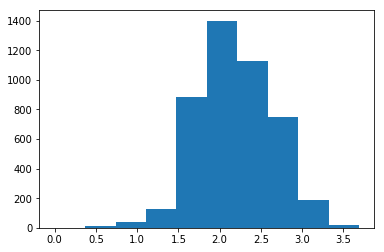

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.log(ytrain+3))

In [31]:
train.shape, future.shape

((16415, 77), (16900,))

In [68]:
df = pd.read_csv("player_df.csv")
print(df.columns)
df.head()

Index(['Unnamed: 0', 'index', 'assists', 'attempted_passes',
       'big_chances_created', 'big_chances_missed', 'bonus', 'bps',
       'clean_sheets', 'clearances_blocks_interceptions', 'completed_passes',
       'creativity', 'dribbles', 'ea_index', 'element',
       'errors_leading_to_goal', 'errors_leading_to_goal_attempt', 'fixture',
       'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'id',
       'influence', 'key_passes', 'kickoff_time', 'kickoff_time_formatted',
       'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses',
       'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed',
       'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves',
       'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals',
       'yellow_cards'],
      dtype='object')


,Unnamed: 0,index,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards
0,0,0,0,3,0,0,0,0,0,0,...,2,2.0,1,0,0,0,55,True,0,0
1,1,1,0,10,1,0,0,7,0,0,...,1,14.0,1,-335,168,503,55,False,0,0
2,2,2,0,5,0,0,0,25,0,0,...,3,17.0,6,-105,427,532,55,True,0,0
3,3,3,0,6,0,0,0,0,0,0,...,2,6.0,1,1700,2609,909,55,False,0,0
4,4,4,0,5,0,0,0,3,0,0,...,1,10.0,1,-719,333,1052,55,True,0,0


In [71]:
details.iloc[:, :20]

,_id,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,dreamteam_count,ea_index,element_type,ep_next,ep_this,event_points,first_name
id,,,,,,,,,,,,,,,,,,,,
1,590481173863452abf32c3ca,0,0,18,100.0,100.0,0,48844,0,0,-3,3,0.0,0,56,1,0.0,2.0,0,David
2,590481173863452abf32c3cb,0,2,637,100.0,100.0,12,11334,1,-1,-1,1,0.1,0,409,1,6.0,14.0,9,Petr
3,590481173863452abf32c3cc,1,19,729,75.0,75.0,10,51507,0,0,1,-1,53.8,3,493,2,1.7,4.9,2,Laurent
4,590481173863452abf32c3cd,0,0,0,100.0,100.0,0,17127,0,0,-2,2,0.0,0,265,2,0.0,2.0,0,Per
5,590481173863452abf32c3ce,0,2,291,100.0,100.0,5,158074,0,0,-2,2,83.5,0,244,2,1.0,4.0,0,Gabriel Armando
6,590481173863452abf32c3cf,5,12,541,100.0,100.0,10,98745,0,0,0,0,484.3,2,541,2,3.8,9.6,14,Héctor
7,590481173863452abf32c3d0,1,3,201,100.0,100.0,6,42427,0,0,-3,3,170.4,1,69,2,4.7,11.4,6,Kieran
8,590481173863452abf32c3d1,0,0,2,100.0,100.0,0,27334,0,0,-4,4,1.4,0,11,2,0.0,2.0,0,Mathieu
9,590481173863452abf32c3d2,0,0,12,100.0,100.0,0,80254,0,0,-2,2,2.0,0,178,2,0.0,2.0,0,Carl


In [81]:
df = pd.read_csv("test_details.csv")
df.head()

,web_name,appearances,appearances_mean10,appearances_mean3,id,minutes,minutes_mean10,minutes_mean3,opponent_1.0,opponent_10.0,...,team_80,team_88,team_90,team_91,total_points,total_points_mean10,total_points_mean3,total_points_mean_all,was_home,web_name.1
0,Ospina,0.0,0.2,0.333333,1.0,0.0,14.3,30.0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.2,0.666667,0.666667,0.0,Ospina
1,Cech,0.0,0.7,0.000000,2.0,0.0,57.7,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,2.6,0.000000,3.250000,0.0,Cech
2,Koscielny,0.0,0.8,0.333333,3.0,0.0,67.5,15.0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,2.9,0.000000,3.821429,0.0,Koscielny
3,Mertesacker,0.0,0.0,0.000000,4.0,0.0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.0,Mertesacker
4,Gabriel,1.0,0.7,1.000000,5.0,90.0,56.9,75.0,NaN,0.0,...,NaN,NaN,NaN,NaN,1.0,1.9,3.333333,2.375000,0.0,Gabriel


In [82]:
df.columns

Index(['web_name', 'appearances', 'appearances_mean10', 'appearances_mean3',
       'id', 'minutes', 'minutes_mean10', 'minutes_mean3', 'opponent_1.0',
       'opponent_10.0', 'opponent_11.0', 'opponent_12.0', 'opponent_13.0',
       'opponent_14.0', 'opponent_15.0', 'opponent_16.0', 'opponent_17.0',
       'opponent_18.0', 'opponent_19.0', 'opponent_2.0', 'opponent_20.0',
       'opponent_3.0', 'opponent_4.0', 'opponent_5.0', 'opponent_6.0',
       'opponent_7.0', 'opponent_8.0', 'opponent_9.0', 'opponent_team',
       'position_1', 'position_2', 'position_3', 'position_4', 'target',
       'target_home', 'target_minutes', 'team_1', 'team_11', 'team_110',
       'team_13', 'team_14', 'team_20', 'team_21', 'team_25', 'team_3',
       'team_31', 'team_35', 'team_43', 'team_56', 'team_57', 'team_6',
       'team_8', 'team_80', 'team_88', 'team_90', 'team_91', 'total_points',
       'total_points_mean10', 'total_points_mean3', 'total_points_mean_all',
       'was_home', 'web_name.1'],
   

In [80]:
test.columns

Index(['appearances', 'appearances_mean10', 'appearances_mean3', 'id',
       'minutes', 'minutes_mean10', 'minutes_mean3', 'opponent_1.0',
       'opponent_10.0', 'opponent_11.0', 'opponent_12.0', 'opponent_13.0',
       'opponent_14.0', 'opponent_15.0', 'opponent_16.0', 'opponent_17.0',
       'opponent_18.0', 'opponent_19.0', 'opponent_2.0', 'opponent_20.0',
       'opponent_3.0', 'opponent_4.0', 'opponent_5.0', 'opponent_6.0',
       'opponent_7.0', 'opponent_8.0', 'opponent_9.0', 'opponent_team',
       'position_1', 'position_2', 'position_3', 'position_4', 'target',
       'target_home', 'target_minutes', 'team_1', 'team_11', 'team_110',
       'team_13', 'team_14', 'team_20', 'team_21', 'team_25', 'team_3',
       'team_31', 'team_35', 'team_43', 'team_56', 'team_57', 'team_6',
       'team_8', 'team_80', 'team_88', 'team_90', 'team_91', 'total_points',
       'total_points_mean10', 'total_points_mean3', 'total_points_mean_all',
       'was_home', 'web_name'],
      dtype='obje

In [30]:
df = pd.read_csv("data.csv")
df.iloc[400:440, -20:]

,minutes_mean10_team,minutes_mean3_team,minutes_mean5_team,minutes_sum_all_team,opponent_team_team,opponent_team_sum_all_team,target_team.1,target_home_team,target_minutes_team,target_team_team,total_points_team,total_points_ewma_team,total_points_mean10_team,total_points_mean3_team,total_points_mean5_team,total_points_mean_all_team,total_points_std10_team,total_points_sum_all_team,was_home_team,was_home_sum_all_team
400,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
401,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
402,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
403,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
404,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
405,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
406,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
407,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
408,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634
409,NaN,24.105691,NaN,144.463415,15.560976,27.585366,3.560976,1.414634,72.463415,21.219512,4.292683,4.090391,NaN,1.430894,NaN,2.70935,NaN,8.390244,0.707317,1.414634


In [22]:
import pandas as pd
df = pd.read_csv("team_pos_data.csv")
df.iloc[:40, :20]

,team_code,element_type,gameweek,minutes,total_points,was_home,opponent_team,appearances,id,target,target_minutes,target_home,target_team,bayes_global,total_points_mean3,minutes_mean3,appearances_mean3,total_points_mean5,minutes_mean5,appearances_mean5
0,1,1,1,90.0,2.0,0.0,4.0,1.0,485,6.0,90.0,2.0,26.0,6.919355,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,90.0,6.0,2.0,26.0,1.0,485,6.0,90.0,0.0,14.0,6.947917,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,3,90.0,6.0,0.0,14.0,1.0,485,2.0,90.0,2.0,20.0,7.000000,4.666667,90.0,1.000000,NaN,NaN,NaN
3,1,1,4,90.0,2.0,2.0,20.0,1.0,485,1.0,90.0,0.0,36.0,6.964706,4.666667,90.0,1.000000,NaN,NaN,NaN
4,1,1,5,90.0,1.0,0.0,36.0,1.0,485,2.0,90.0,2.0,16.0,6.904762,3.000000,90.0,1.000000,3.4,90.0,1.0
5,1,1,6,90.0,2.0,2.0,16.0,1.0,485,3.0,90.0,2.0,28.0,6.869048,1.666667,90.0,1.000000,3.4,90.0,1.0
6,1,1,7,90.0,3.0,2.0,28.0,1.0,485,8.0,90.0,0.0,18.0,6.858108,2.000000,90.0,1.000000,2.8,90.0,1.0
7,1,1,8,90.0,8.0,0.0,18.0,1.0,485,0.0,90.0,0.0,8.0,6.964912,4.333333,90.0,1.000000,3.2,90.0,1.0
8,1,1,9,90.0,0.0,0.0,8.0,1.0,485,6.0,90.0,2.0,6.0,6.884615,3.666667,90.0,1.000000,2.8,90.0,1.0
9,1,1,10,90.0,6.0,2.0,6.0,1.0,485,2.0,90.0,0.0,32.0,6.943182,4.666667,90.0,1.000000,3.8,90.0,1.0


In [28]:
cumsums = df.groupby(["team_code", "element_type"]).shift().cumsum()
cummeans = cumsums / cumsums["appearances"]
cumsums.div(cumsums["appearances"], axis=0).head(40)

,appearances,appearances_ewma,appearances_mean10,appearances_mean3,appearances_mean5,appearances_sum_all,bayes_global,gameweek,id,minutes,...,total_points,total_points_ewma,total_points_mean10,total_points_mean3,total_points_mean5,total_points_mean_all,total_points_std10,total_points_sum_all,was_home,was_home_sum_all
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.000000,NaN,NaN,NaN,1.000000,6.919355,1.000000,485.000,90.000000,...,2.000000,2.000000,NaN,NaN,NaN,1.000000,NaN,2.000000,0.000000,0.000000
2,1.0,1.000000,NaN,NaN,NaN,1.500000,6.933636,1.500000,485.000,90.000000,...,4.000000,3.034643,NaN,NaN,NaN,1.833333,NaN,5.000000,1.000000,1.000000
3,1.0,1.000000,NaN,0.333333,NaN,2.000000,6.955757,2.000000,485.000,90.000000,...,4.666667,3.609078,NaN,1.555556,NaN,2.388889,NaN,8.000000,0.666667,1.333333
4,1.0,1.000000,NaN,0.500000,NaN,2.500000,6.957994,2.500000,485.000,90.000000,...,4.000000,3.705610,NaN,2.333333,NaN,2.591667,NaN,10.000000,1.000000,2.000000
5,1.0,1.000000,NaN,0.600000,0.200000,3.000000,6.947348,3.000000,485.000,90.000000,...,3.400000,3.626564,NaN,2.466667,0.680000,2.640000,NaN,11.400000,0.800000,2.400000
6,1.0,1.000000,NaN,0.666667,0.333333,3.500000,6.934298,3.500000,485.000,90.000000,...,3.166667,3.530882,NaN,2.333333,1.133333,2.652381,NaN,12.666667,1.000000,3.000000
7,1.0,1.000000,NaN,0.714286,0.428571,4.000000,6.923414,4.000000,485.000,90.000000,...,3.142857,3.461232,NaN,2.285714,1.371429,2.666327,NaN,14.000000,1.142857,3.714286
8,1.0,1.000000,NaN,0.750000,0.500000,4.500000,6.928601,4.500000,485.000,90.000000,...,3.750000,3.506473,NaN,2.541667,1.600000,2.749702,NaN,16.000000,1.000000,4.250000
9,1.0,1.000000,NaN,0.777778,0.555556,5.000000,6.923714,5.000000,485.000,90.000000,...,3.333333,3.480367,NaN,2.666667,1.733333,2.777513,NaN,17.555556,0.888889,4.666667


In [33]:
import pandas as pd
df = pd.read_csv("data.csv")
df.iloc[400:410]

,Unnamed: 0,minutes,total_points,was_home,opponent_team,appearances,id,team_code,web_name,element_type,...,minutes_ewma,appearances_ewma,total_points_mean_all,minutes_sum_all,total_points_sum_all,was_home_sum_all,opponent_team_sum_all,appearances_sum_all,total_points_team,total_points_team.1
400,400,0.0,0.0,1.0,3.0,0.0,11,25,Chambers,2,...,45.862325,0.509581,3.300000,1710.0,66.0,15.0,329.0,19.0,3.268253,3.322532
401,401,0.0,0.0,1.0,1.0,0.0,11,25,Chambers,2,...,42.416042,0.471289,3.300000,1710.0,66.0,16.0,330.0,19.0,3.269317,3.325257
402,402,90.0,0.0,0.0,2.0,1.0,11,25,Chambers,2,...,45.962694,0.510697,3.142857,1800.0,66.0,16.0,332.0,20.0,3.265521,3.322767
403,403,90.0,6.0,1.0,15.0,1.0,11,25,Chambers,2,...,49.220345,0.546893,3.272727,1890.0,72.0,17.0,347.0,21.0,3.257915,3.318075
404,404,90.0,8.0,1.0,10.0,1.0,11,25,Chambers,2,...,52.216020,0.580178,3.478261,1980.0,80.0,18.0,357.0,22.0,3.260660,3.318803
405,405,90.0,1.0,0.0,4.0,1.0,11,25,Chambers,2,...,54.973726,0.610819,3.375000,2070.0,81.0,18.0,361.0,23.0,3.258977,3.318745
406,406,90.0,1.0,1.0,13.0,1.0,11,25,Chambers,2,...,57.514862,0.639054,3.280000,2160.0,82.0,19.0,374.0,24.0,3.253251,3.316553
407,407,90.0,2.0,1.0,9.0,1.0,12,3,Sánchez,3,...,90.000000,1.000000,1.000000,90.0,2.0,1.0,9.0,1.0,NaN,NaN
408,408,90.0,3.0,0.0,8.0,1.0,12,3,Sánchez,3,...,90.000000,1.000000,1.666667,180.0,5.0,1.0,17.0,2.0,3.353057,3.384505
409,409,90.0,16.0,0.0,18.0,1.0,12,3,Sánchez,3,...,90.000000,1.000000,5.250000,270.0,21.0,1.0,35.0,3.0,3.375000,3.376420
